In [17]:
!pip -q install -U "transformers>=4.44" accelerate peft safetensors
!pip -q install -U bitsandbytes


In [18]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.utils.data import Dataset


## **Dataset + Data Preparation**
**Load Dataset**

In [19]:
import json


file_path = "dataset_pmb_uajy.json"

try:
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)


    if not isinstance(data, list):
        raise ValueError("JSON harus berupa LIST of objects")


    required = {"category", "instruction", "input", "output"}
    for i, ex in enumerate(data[:20]):  # cek 20 pertama
        missing = required - set(ex.keys())
        if missing:
            raise ValueError(f"Index {i} missing keys: {missing}")

    categories = sorted({d["category"] for d in data})

    print("✅ JSON berhasil dibaca")
    print("Jumlah data :", len(data))
    print("Categories  :", categories)
    print("Contoh data:", data[0])

except FileNotFoundError:
    print(f"❌ File '{file_path}' tidak ditemukan. Pastikan nama file & lokasi benar.")
except json.JSONDecodeError:
    print("❌ Format JSON tidak valid. Cek koma, kurung, dll.")
except Exception as e:
    print("❌ Error lain:", e)


✅ JSON berhasil dibaca
Jumlah data : 463
Categories  : ['Alur', 'Beasiswa', 'Biaya', 'PMB_Umum', 'Pembayaran', 'Prodi', 'Profesi', 'S1', 'S2', 'S3', 'Umum']
Contoh data: {'category': 'S1', 'instruction': 'Jawablah pertanyaan berikut berdasarkan informasi resmi PMB Universitas Atma Jaya Yogyakarta.', 'input': 'Siapa saja yang dapat mendaftar Program Sarjana (S1) di Universitas Atma Jaya Yogyakarta melalui Program Nilai Ijazah?', 'output': 'Program Nilai Ijazah terbuka bagi siswa SMA/SMK yang telah menyelesaikan studi (Lulusan tahun 2026 dan sebelumnya) yang penerimaannya didasarkan pada nilai ijazah.'}


**Split train/val/test stratified by category**

In [20]:
from sklearn.model_selection import train_test_split

labels = [d["category"] for d in data]

train_data, temp_data = train_test_split(
    data, test_size=0.2, random_state=42, shuffle=True, stratify=labels
)

temp_labels = [d["category"] for d in temp_data]
val_data, test_data = train_test_split(
    temp_data, test_size=0.5, random_state=42, shuffle=True, stratify=temp_labels
)

print(len(train_data), len(val_data), len(test_data))


370 46 47


**Templating**

In [21]:
def format_prompt(category: str, instruction: str, inp: str) -> str:
    category = (category or "").strip()
    instruction = (instruction or "").strip()
    inp = (inp or "").strip()

    header = f"### Category: {category}\n### Instruction:\n{instruction}\n\n"
    if inp:
        return header + f"### Input:\n{inp}\n\n### Response:\n"
    else:
        return header + "### Response:\n"


## **Tokenization & Prompt Formatting**
**Tokenization**

In [22]:
model_id = "Sahabat-AI/gemma2-9b-cpt-sahabatai-v1-base"
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=False)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

MAX_LEN = 1024

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=1024):
        self.data = data
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        ex = self.data[idx]

        prompt = format_prompt(
            ex.get("category", ""),
            ex.get("instruction", ""),
            ex.get("input", "")
        )
        answer = (ex.get("output", "") or "").strip()

        full_text = prompt + answer + self.tok.eos_token

        enc = self.tok(
            full_text,
            truncation=True,
            max_length=self.max_len,
        )

        input_ids = enc["input_ids"]
        attention_mask = enc["attention_mask"]

        prompt_ids = self.tok(
            prompt,
            truncation=True,
            max_length=self.max_len,
        )["input_ids"]

        labels = input_ids.copy()

        for i in range(min(len(prompt_ids), len(labels))):
            labels[i] = -100

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long),
        }

train_ds = InstructionDataset(train_data, tokenizer, MAX_LEN)
val_ds   = InstructionDataset(val_data, tokenizer, MAX_LEN)
test_ds  = InstructionDataset(test_data, tokenizer, MAX_LEN)


**Collate function (padding batch)**

In [23]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    input_ids = pad_sequence([x["input_ids"] for x in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence([x["attention_mask"] for x in batch], batch_first=True, padding_value=0)
    labels = pad_sequence([x["labels"] for x in batch], batch_first=True, padding_value=-100)

    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}


**Test DataLoader + sanity check decode**

In [24]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=collate_fn)
batch = next(iter(train_loader))
print({k: v.shape for k, v in batch.items()})


sample = train_data[0]
print("\n--- Preview ---")
print(format_prompt(sample["category"], sample["instruction"], sample.get("input","")) + sample["output"][:200])


{'input_ids': torch.Size([2, 78]), 'attention_mask': torch.Size([2, 78]), 'labels': torch.Size([2, 78])}

--- Preview ---
### Category: Profesi
### Instruction:
Sebutkan minimal IPK yang disyaratkan untuk mendaftar PPAr UAJY.

### Input:
Minimal IPK PPAr UAJY

### Response:
Minimal IPK yang disyaratkan untuk mendaftar PPAr UAJY adalah 3,00.


## **Fine Tunning**
**Load model**

In [25]:
import torch
from transformers import AutoModelForCausalLM

model_id = "Sahabat-AI/gemma2-9b-cpt-sahabatai-v1-base"

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto"
)

print("Model Sahabat-AI loaded")


`torch_dtype` is deprecated! Use `dtype` instead!
The following generation flags are not valid and may be ignored: ['cache_implementation']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model Sahabat-AI loaded


**LoRA**

In [26]:
!pip -q install peft

In [27]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 4,472,832 || all params: 9,246,178,816 || trainable%: 0.0484


**Training Loop**

In [28]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-4)
model.train()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Gemma2ForCausalLM(
      (model): Gemma2Model(
        (embed_tokens): Embedding(256000, 3584, padding_idx=0)
        (layers): ModuleList(
          (0-41): 42 x Gemma2DecoderLayer(
            (self_attn): Gemma2Attention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=3584, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3584, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_p

**Hitung Loss awal (1 batch)**

In [29]:
batch = next(iter(train_loader))
batch = {k: v.to(model.device) for k, v in batch.items()}

with torch.no_grad():
    out = model(**batch)
    print("Initial loss:", out.loss.item())


Initial loss: 1.5006288290023804


In [30]:
EPOCHS = 1

for epoch in range(EPOCHS):
    total_loss = 0
    for step, batch in enumerate(train_loader):
        batch = {k: v.to(model.device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

        if step % 50 == 0:
            print(f"Epoch {epoch} Step {step} Loss {loss.item():.4f}")

    print(f"Epoch {epoch} Avg loss:", total_loss / len(train_loader))


Epoch 0 Step 0 Loss 2.1419
Epoch 0 Step 50 Loss 1.0239
Epoch 0 Step 100 Loss 1.1645
Epoch 0 Step 150 Loss 1.3428
Epoch 0 Avg loss: 1.3126396888011211


**Save Adapter**

In [31]:
save_dir = "gemma2b_lora_adapter"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print("Adapter saved to", save_dir)


Adapter saved to gemma2b_lora_adapter


## **Model Prediction/ Demo**

**Load base model + adapter (untuk inference)**

In [32]:
from peft import PeftModel

base_model_id = "Sahabat-AI/gemma2-9b-cpt-sahabatai-v1-base"
adapter_dir = "./gemma2b_lora_adapter"

tokenizer = AutoTokenizer.from_pretrained(base_model_id)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype=torch.float16,
    device_map="auto"
)

model = PeftModel.from_pretrained(base_model, adapter_dir)
model.eval()


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Gemma2ForCausalLM(
      (model): Gemma2Model(
        (embed_tokens): Embedding(256000, 3584, padding_idx=0)
        (layers): ModuleList(
          (0-41): 42 x Gemma2DecoderLayer(
            (self_attn): Gemma2Attention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=3584, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3584, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_p

**Fungsi generate jawaban**

In [33]:
def generate_answer(sample, max_new_tokens=200):
    prompt = format_prompt(sample["category"], sample["instruction"], sample.get("input",""))
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            temperature=0.0,
            pad_token_id=tokenizer.eos_token_id
        )

    text = tokenizer.decode(out[0], skip_special_tokens=True)

    # ambil bagian setelah "### Response:"
    marker = "### Response:"
    if marker in text:
        return text.split(marker, 1)[1].strip()
    return text.strip()


**Generate untuk test set + simpan**

In [34]:
import json

pred_test = []
for s in test_data:
    s2 = dict(s)
    s2["model_response"] = generate_answer(s2, max_new_tokens=200)
    pred_test.append(s2)

out_path = "test_predictions.json"
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(pred_test, f, ensure_ascii=False, indent=2)

print("Saved:", out_path)


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Saved: test_predictions.json


## **Model Evaluation (LLM-based Scoring)**
**Setup Judge**


In [ ]:
import os
os.environ["HF_TOKEN"] = "token_goes_here"

In [36]:
from llm_client_hf import LLMClientHF

judge = LLMClientHF(model_name="microsoft/Phi-3-mini-4k-instruct")  # boleh ganti ke model lain
SYSTEM = 'You are a strict grader. Return ONLY JSON: {"score":0-5,"reason":"..."}'


[LLMClientHF] Loading microsoft/Phi-3-mini-4k-instruct on cuda ...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


[LLMClientHF] Ready.


In [37]:
import re
import json
import numpy as np

def judge_prompt(sample):
    return f"""
Nilai jawaban model berikut dari 0 sampai 5.
Balas HANYA JSON valid: {{"score":0-5,"reason":"singkat"}}

Instruction: {sample["instruction"]}
Input: {sample.get("input","")}
Expected: {sample["output"]}
Model Response: {sample["model_response"]}
""".strip()

def parse_score(text):
    m = re.search(r"\{.*\}", text, flags=re.DOTALL)
    if not m:
        return None
    try:
        obj = json.loads(m.group(0))
        score = int(obj.get("score"))
        if 0 <= score <= 5:
            return score, str(obj.get("reason","")).strip()
    except:
        return None
    return None


**Menjalankan scoring + stats**

In [ ]:
from llm_client_hf import LLMClientHF

judge = LLMClientHF(model_name="microsoft/Phi-3-mini-4k-instruct")  
SYSTEM = 'You are a strict grader. Return ONLY JSON: {"score":0-5,"reason":"..."}'


[LLMClientHF] Loading microsoft/Phi-3-mini-4k-instruct on cuda ...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


[LLMClientHF] Ready.


In [39]:
def judge_prompt(s):
    return f"""
Nilai jawaban model pada skala 0-5.
Balas HANYA JSON valid persis format ini:
{{"score": <0-5>, "reason": "<singkat>"}}

Instruction: {s["instruction"]}
Input: {s.get("input","")}
Expected: {s["output"]}
Model: {s["model_response"]}
""".strip()

def parse_score(text: str):
    m = re.search(r"\{.*\}", text, flags=re.DOTALL)
    if not m:
        return None
    try:
        obj = json.loads(m.group(0))
        score = int(obj.get("score"))
        if 0 <= score <= 5:
            return score, str(obj.get("reason","")).strip()
    except:
        return None
    return None


In [41]:
def judge_call(prompt, max_tokens=160, temperature=0.0):
    return judge.ask(prompt, system=SYSTEM, max_tokens=max_tokens, temperature=temperature)


In [42]:
scored = []
invalid = 0

for s in pred_test:
    prompt = judge_prompt(s)
    resp = judge.ask(prompt, system=SYSTEM, max_tokens=160, temperature=0.0)  # <-- ini

    parsed = parse_score(resp)

    s2 = dict(s)
    if parsed is None:
        invalid += 1
        s2["judge_score"] = None
        s2["judge_reason"] = "INVALID_JUDGE_OUTPUT"
        s2["judge_raw"] = resp[:200]
    else:
        s2["judge_score"], s2["judge_reason"] = parsed

    scored.append(s2)


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [43]:
valid_scores = [x["judge_score"] for x in scored if x["judge_score"] is not None]
stats = {
    "n_total": len(scored),
    "n_valid": len(valid_scores),
    "n_invalid": invalid,
    "mean": sum(valid_scores)/len(valid_scores) if valid_scores else None,
}
print(stats)


{'n_total': 47, 'n_valid': 31, 'n_invalid': 16, 'mean': 2.967741935483871}


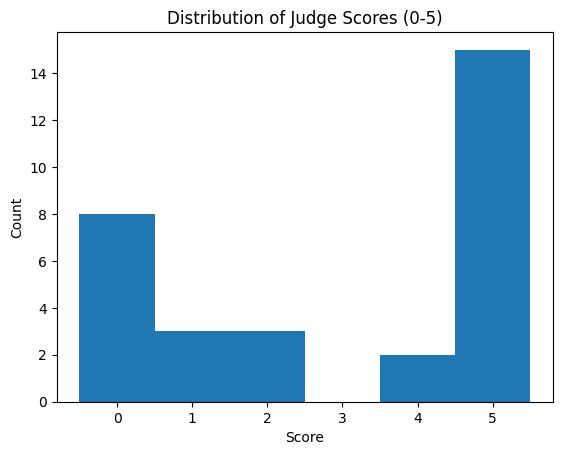

n_total: 47
n_valid: 31
mean: 2.967741935483871


In [44]:
import json
import matplotlib.pyplot as plt

scores = [x["judge_score"] for x in scored if x.get("judge_score") is not None]

plt.figure()
plt.hist(scores, bins=range(0,7), align="left")
plt.title("Distribution of Judge Scores (0-5)")
plt.xlabel("Score")
plt.ylabel("Count")
plt.xticks(range(0,6))
plt.show()

print("n_total:", len(scored))
print("n_valid:", len(scores))
print("mean:", sum(scores)/len(scores) if scores else None)
